In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Required Libraries

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Importing DataSet

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')

data = pd.DataFrame(data)

In [ ]:
data.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375,162.769570
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375,55.230459
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375,102.697189
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375,148.317051
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375,71.315157


In [ ]:
original_data_x = data.iloc[:,:11]
original_data_x.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
0,376.228731,376.105858,375.982985,375.860112,375.737238,375.614365,375.491492,375.368619,375.245746,375.122873,375
1,378.621190,378.259071,377.896952,377.534833,377.172714,376.810595,376.448476,376.086357,375.724238,375.362119,375
2,376.947473,376.752726,376.557978,376.363231,376.168484,375.973736,375.778989,375.584242,375.389495,375.194747,375
3,376.348463,376.213616,376.078770,375.943924,375.809078,375.674231,375.539385,375.404539,375.269693,375.134846,375
4,377.804453,377.524008,377.243562,376.963117,376.682672,376.402226,376.121781,375.841336,375.560891,375.280445,375


In [ ]:
# Define the standard deviation of the noise
noise_stddev = 0.05  # Adjust this value as needed

# Add random noise to the DataFrame
noise = np.random.normal(0, noise_stddev, size=original_data_x.shape)
original_data_x = original_data_x + noise

In [ ]:
y = data.iloc[:,-1]
y.head()

0    162.769570
1     55.230459
2    102.697189
3    148.317051
4     71.315157
Name: k, dtype: float64

In [ ]:
result = pd.concat([original_data_x, y], axis=1)
result.head()

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,k
0,376.855477,376.727077,375.993117,375.191142,376.422008,375.039190,375.539410,375.382498,375.225109,375.540818,375.793140,162.769570
1,378.660504,378.485413,377.122480,377.117844,376.895047,376.947333,378.127233,375.822368,375.753114,375.777656,374.777807,55.230459
2,376.334193,376.737755,376.342726,375.751359,374.799954,376.010779,376.356229,375.292529,375.240280,375.132166,375.258579,102.697189
3,376.107953,376.194229,377.030925,376.100844,375.116039,375.343445,376.089242,375.311144,375.044370,374.203964,374.422731,148.317051
4,378.006565,377.343298,376.870823,376.671632,376.713821,376.356920,376.205327,376.271108,375.234301,375.654327,373.987765,71.315157


In [ ]:
# from sklearn.preprocessing import StandardScaler
# #Create a StandardScaler instance
# scaler = StandardScaler()

# # Standardize the DataFrame and create a new DataFrame
# result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Normalize the DataFrame and create a new DataFrame
result = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

print("\nNormalized DataFrame:")
print(result)


Normalized DataFrame:
            0      0.02      0.04      0.06      0.08       0.1      0.12  \
0    0.120916  0.097854  0.095026  0.040462  0.175932  0.104642  0.175177   
1    0.212094  0.197327  0.168250  0.169918  0.211393  0.274856  0.450684   
2    0.094585  0.098458  0.117693  0.078104  0.054334  0.191311  0.262138   
3    0.083157  0.067710  0.162314  0.101586  0.078030  0.131782  0.233713   
4    0.179061  0.132715  0.151934  0.139937  0.197807  0.222189  0.246072   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.094221  0.058252  0.083895  0.026062  0.148241  0.157294  0.159527   
996  0.075661  0.053438  0.057479  0.084439  0.052308  0.128191  0.209951   
997  0.158543  0.142288  0.184811  0.093195  0.184646  0.185421  0.127396   
998  0.060073  0.103920  0.121169  0.157134  0.121181  0.132091  0.238058   
999  0.106910  0.043913  0.048448  0.109184  0.134446  0.113013  0.179419   

         0.14      0.16      0.18       0.2         

In [ ]:
result = result.sample(frac=1.0, random_state=100)  # Set a random_state for reproducibility

In [ ]:
x_train = result.iloc[:900,:-1]
x_test = result.iloc[900:,:-1]
x_train.shape, x_test.shape

((900, 11), (100, 11))

In [ ]:
y_train = result.iloc[:900,-1]
y_test = result.iloc[900:,-1]
y_train.shape, y_test.shape

((900,), (100,))

In [ ]:
# Load Toy Example Data
training_feature = x_train
ground_truth_k = y_train

testing_feature_sk = x_test
testing_score = y_test

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [ ]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_k = (1, )

intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 1
latent_dim = 1
epochs = 20

# VAE model = encoder + decoder
# build encoder model

inputs_x = Input(shape=input_shape_x, name='temp_input')
inputs_k = Input(shape=input_shape_k, name='ground_truth')

inputs_x_dropout = Dropout(0.25)(inputs_x)

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,inputs_k], [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim, activation = 'linear')(inter_y3)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder([inputs_x,inputs_k])[2])
vae = Model([inputs_x,inputs_k], [outputs], name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 11)]                 0         []                            
                                                                                                  
 dropout_3 (Dropout)         (None, 11)                   0         ['temp_input[0][0]']          
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    96        ['dropout_3[0][0]']           
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1

## Loss Function

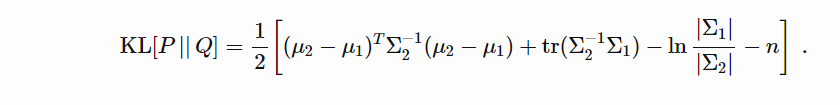

In [ ]:
def kl_divergence_multivariate_normal_keras(mu_p, log_var_p, mu_q, log_var_q):
    sigma_p = K.exp(log_var_p)            ## log variance to variance
    sigma_q = K.exp(log_var_q)

    term1 = K.sum(sigma_p / sigma_q)
    term2 = K.sum(K.square(mu_q - mu_p) / sigma_q)
    term3 = -1
    term4 = K.sum(log_var_q - log_var_p)

    return 0.5 * (term1 + term2 + term3 + term4)

In [ ]:
from tensorflow.keras.optimizers import Adam
import numpy as np
from numpy.linalg import det, inv

##Customize Lost Function of the VAE Model
models = (encoder, decoder)

reconstruction_loss = mse(inputs_x,outputs)
reconstruction_loss = K.abs(reconstruction_loss)


kl_loss = kl_divergence_multivariate_normal_keras(inputs_k, K.constant([0.0]), z_mean, z_log_var)

label_loss = kl_divergence_multivariate_normal_keras(z_mean, z_log_var, inputs_k, K.constant([0.0]))
vae_loss = K.mean(reconstruction_loss + kl_loss + label_loss)

vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer)
vae.summary()
vae.save_weights('random_weights.h5')

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temp_input (InputLayer)     [(None, 11)]                 0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 1),                  167       ['temp_input[0][0]',          
                              (None, 1),                             'ground_truth[0][0]']        
                              (None, 1)]                                                          
                                                                                            

In [ ]:
# Train the VAE model with validation data
history = vae.fit([x_train, y_train], epochs=epochs,batch_size=batch_size)  # Validation data)

Epoch 1/20
900/900 [==============================] - 4s 2ms/step - loss: 0.0645
Epoch 2/20
900/900 [==============================] - 2s 2ms/step - loss: 0.0519
Epoch 3/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0536
Epoch 4/20
900/900 [==============================] - 3s 4ms/step - loss: 0.0512
Epoch 5/20
900/900 [==============================] - 2s 3ms/step - loss: 0.0529
Epoch 6/20
900/900 [==============================] - 2s 3ms/step - loss: 0.0531
Epoch 7/20
900/900 [==============================] - 2s 3ms/step - loss: 0.0523
Epoch 8/20
900/900 [==============================] - 2s 2ms/step - loss: 0.0554
Epoch 9/20
900/900 [==============================] - 3s 3ms/step - loss: 0.0519
Epoch 10/20
900/900 [==============================] - 3s 4ms/step - loss: 0.0520
Epoch 11/20
900/900 [==============================] - 2s 3ms/step - loss: 0.0536
Epoch 12/20
900/900 [==============================] - 2s 3ms/step - loss: 0.0530
Epoch 13/20
900/900 [====

In [ ]:
[z_mean, z_log_var, z] = encoder.predict([x_train,y_train],batch_size=batch_size)

900/900 [==============================] - 2s 2ms/step


Mean squared error: 0.010
R2 Variance score: 0.873


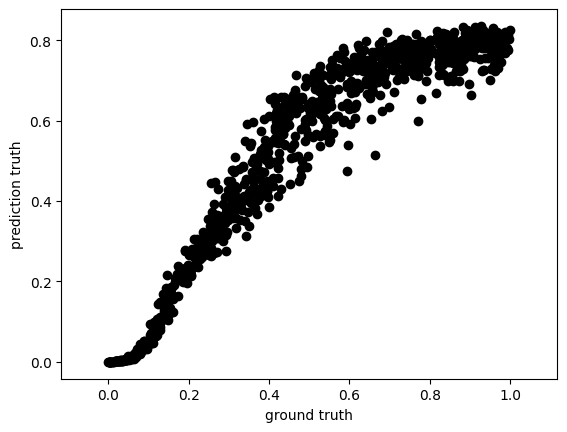

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_train, z_mean))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_train, z_mean))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_train, z_mean,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [ ]:
[z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test,y_test],batch_size=batch_size)

100/100 [==============================] - 0s 2ms/step


Mean squared error: 0.014
R2 Variance score: 0.811


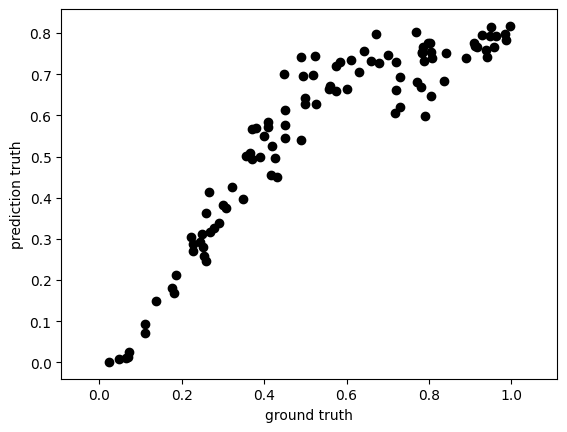

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(y_test, z_mean_t))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(y_test, z_mean_t))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_test, z_mean_t,  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error, r2_score

# # Assuming 'result' is your DataFrame containing the data

# # Define the number of splits (folds) for cross-validation
# num_splits = 5  # You can adjust this as needed

# # Initialize KFold cross-validation splitter
# kf = KFold(n_splits=num_splits, shuffle=True, random_state=11)

# # Initialize lists to store RMSE and R2 scores
# rmse_scores = []
# r2_scores = []

# # Iterate over the splits
# for train_idx, test_idx in kf.split(result):
#     # Split the data into training and testing sets for this fold
#     train_data = result.iloc[train_idx]
#     test_data = result.iloc[test_idx]

#     x_train = train_data.iloc[:, :-1]
#     y_train = train_data.iloc[:, -1]

#     x_test = test_data.iloc[:, :-1]
#     y_test = test_data.iloc[:, -1]

#     # Train the VAE model (assuming 'vae' is already defined)
#     history = vae.fit([x_train, y_train], epochs=epochs, batch_size=batch_size, verbose=0)

#     # Predict and evaluate on the training set
#     [z_mean, z_log_var, z] = encoder.predict([x_train, y_train], batch_size=batch_size)
#     rmse_train = np.sqrt(mean_squared_error(y_train, z_mean))
#     r2_train = r2_score(y_train, z_mean)

#     # Predict and evaluate on the test set
#     [z_mean_t, z_log_var_t, z_t] = encoder.predict([x_test, y_test], batch_size=batch_size)
#     rmse_test = np.sqrt(mean_squared_error(y_test, z_mean_t))
#     r2_test = r2_score(y_test, z_mean_t)

#     # Append RMSE and R2 scores for this fold
#     rmse_scores.append(rmse_test)
#     r2_scores.append(r2_test)

# # Calculate the average RMSE and R2 scores across all folds
# average_rmse = np.mean(rmse_scores)
# average_r2 = np.mean(r2_scores)

# print(f'Average RMSE: {average_rmse}')
# print(f'Average R2 score: {average_r2}')

200/200 [==============================] - 1s 2ms/step
Average RMSE: 0.054879491212097856
Average R2 score: 0.9562773925074077


In [ ]:
r2_train

0.9828550668158227

In [ ]:
x_test

,0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2
353,0.282679,0.279928,0.281470,0.286913,0.283684,0.288552,0.276622,0.296646,0.284953,0.342956,0.576986
633,0.025918,0.028773,0.030916,0.031481,0.025953,0.044015,0.047014,0.040598,0.045229,0.099150,0.363356
395,0.036741,0.037192,0.035672,0.036152,0.037800,0.042063,0.039037,0.049468,0.081922,0.117547,0.633061
923,0.082454,0.101959,0.092583,0.099859,0.094169,0.100975,0.102866,0.098086,0.110162,0.156220,0.472019
315,0.030904,0.026874,0.030213,0.032763,0.030378,0.038136,0.045629,0.042847,0.034406,0.088037,0.550928
...,...,...,...,...,...,...,...,...,...,...,...
875,0.083706,0.088414,0.083427,0.097385,0.097729,0.090218,0.091144,0.099422,0.125425,0.143830,0.449266
228,0.139366,0.140893,0.142313,0.141606,0.150785,0.148350,0.141189,0.141345,0.159737,0.204890,0.089997
526,0.082992,0.083921,0.083230,0.084585,0.083077,0.089019,0.090725,0.113936,0.121076,0.156244,0.460024
79,0.132173,0.140283,0.133969,0.136457,0.143715,0.135881,0.128485,0.147823,0.188609,0.157502,0.783775


In [ ]:
y_test

353    0.119794
633    0.700918
395    0.650088
923    0.361094
315    0.691554
         ...   
875    0.371415
228    0.250120
526    0.380439
79     0.259064
871    0.784068
Name: k, Length: 200, dtype: float64

In [ ]:
# train original data
y_train_np = y_train.to_numpy().reshape(-1, 1)
concatenated_data_train = np.concatenate((x_train, y_train_np), axis=1)
original_data_restored_train = scaler.inverse_transform(concatenated_data_train)
original_data_restored_train.shape

(800, 12)

In [ ]:
# test original data
y_test_np = y_test.to_numpy().reshape(-1, 1)
concatenated_data_test = np.concatenate((x_test, y_test_np), axis=1)
original_data_restored_test = scaler.inverse_transform(concatenated_data_test)
original_data_restored_test.shape

(200, 12)

In [ ]:
# Use the decoder to generate predictions
predictions_train = decoder.predict(z)
predictions_test = decoder.predict(z_t)

7/7 [==============================] - 0s 3ms/step


In [ ]:
# train decoded data
decoded_data_train = np.concatenate((predictions_train, z_mean), axis=1)
decoded_data_train_rescaled = scaler.inverse_transform(decoded_data_train)
decoded_data_train_rescaled.shape

(800, 12)

In [ ]:
# train decoded data
decoded_data_test = np.concatenate((predictions_test, z_mean_t), axis=1)
decoded_data_test_rescaled = scaler.inverse_transform(decoded_data_test)
decoded_data_test_rescaled.shape

(200, 12)

Mean squared error: 50.773
R2 Variance score: 0.983


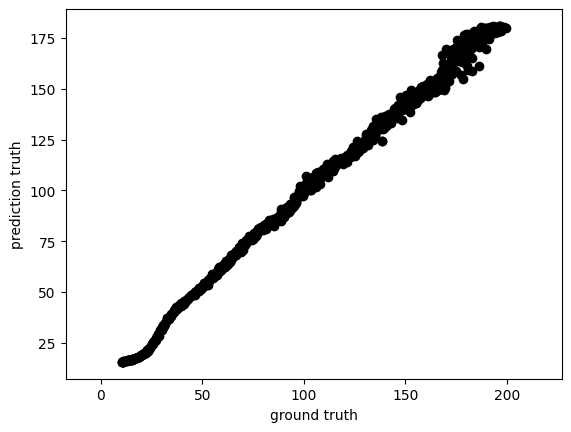

In [ ]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_train[:,-1], decoded_data_train_rescaled[:,-1],  color='black')
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

Mean squared error: 45.341
R2 Variance score: 0.983


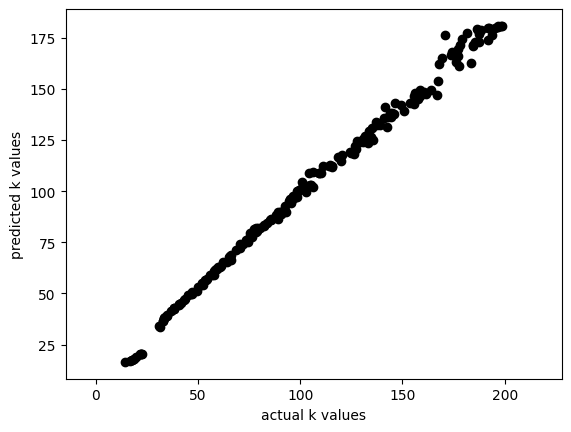

In [ ]:
## Test Data
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(original_data_restored_test[:,-1], decoded_data_test_rescaled[:,-1],  color='black')
plt.xlabel('actual k values')
plt.ylabel('predicted k values')
ax.axis('equal');

800/800 [==============================] - 2s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(-0.44600702578358786,
 0.16983727424949804,
 -0.1765566327408079,
 0.037496026778044825)

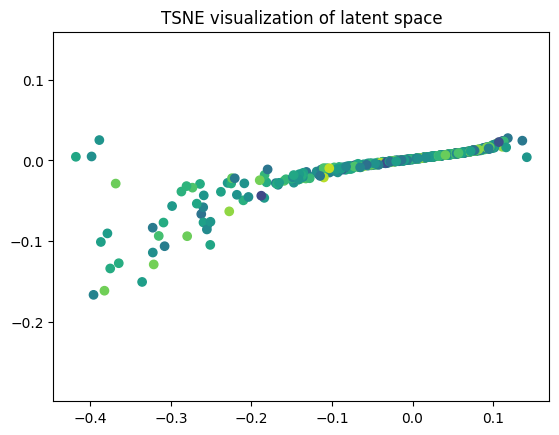

In [ ]:
## Visualize Latent Space
vae.load_weights('random_weights.h5')
# vae.fit([training_feature,ground_truth_r],
#          epochs=epochs,
#          batch_size=batch_size,
#          verbose = 0)

[z_mean, z_log_var, z] = encoder.predict([x_train,y_train],batch_size=batch_size)

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c= z)
plt.title('TSNE visualization of latent space')
ax.axis('equal')

In [ ]:
std_deviation_z_t = np.sqrt(np.exp(z_log_var_t))
std_deviation_z_t[:5]

array([[1.0117077],
       [1.0001382],
       [1.0025023],
       [1.009629 ],
       [1.0002373]], dtype=float32)

## Bayesian Results

162.70020036535794
0.18077766863406217


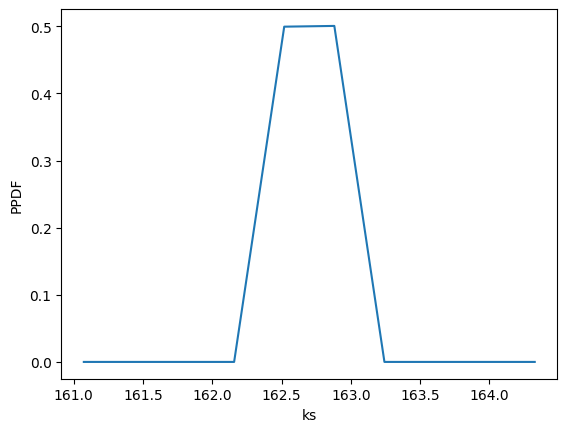

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Problem Parameters
q = 1000
L = 0.2
TL = 375
sig_m = 0.05
x = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
T = np.array([376.228731, 376.105858,	375.982985,	375.860112,	375.737238,	375.614365,	375.491492,	375.368619,	375.245746,	375.122873,	375])
Nm = len(x)

# Priors
mu_k = 162.7
sigma_k = 0.01 * mu_k

kmin = mu_k - sigma_k
kmax = mu_k + sigma_k
Ns = 10
ks = np.linspace(kmin, kmax, Ns)

Tsim = np.zeros((Ns, Nm))
P1 = np.zeros(Ns)
P2 = np.zeros(Ns)
P3a = np.zeros(Ns)

for i in range(Ns):
    Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
    e = Tsim[i, :] - T
    A = np.sum(e**2)
    B = (ks[i] - mu_k)**2 / sigma_k**2
    S = A + B
    f = -0.5 * S / sig_m**2
    P1[i] = np.exp(f)
    P2[i] = ks[i] * P1[i]
    P3a[i] = ks[i]**2 * P1[i]
Den = np.sum(P1)
PPDF = P1 / Den
km = np.sum(P2) / Den
print(km)
vark = np.sum(P3a) / Den - km**2
sq = np.sqrt(vark)
print(sq)
# Plot the data
plt.plot(ks, PPDF, '-')
plt.xlabel('ks')
plt.ylabel('PPDF')
plt.show()

In [ ]:
import numpy as np

# Define an array of different k values
k_values = original_data_restored_test[:,-1]

# Define a 2D array of different T values
T_values_2d = original_data_restored_test[:,:-1]
# Initialize lists to store km and sq values for each set
km_list = []
sq_list = []

# Problem Parameters
q = 1000
L = 0.2
TL = 375
sig_m = 0.05
x = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2])
Nm = len(x)

# Priors
Ns = 10

for k, T_values in zip(k_values, T_values_2d):
        sigma_k = 0.01 * k
        kmin = k - sigma_k
        kmax = k + sigma_k
        ks = np.linspace(kmin, kmax, Ns)

        Tsim = np.zeros((Ns, Nm))
        P1 = np.zeros(Ns)
        P2 = np.zeros(Ns)
        P3a = np.zeros(Ns)

        for i in range(Ns):
            Tsim[i, :] = -q / ks[i] * x + q * L / ks[i] + TL
            e = Tsim[i, :] - T_values
            A = np.sum(e**2)
            B = (ks[i] - k)**2 / sigma_k**2
            S = A + B
            f = -0.5 * S / sig_m**2
            P1[i] = np.exp(f)
            P2[i] = ks[i] * np.exp(f)
            P3a[i] = ks[i]**2 * np.exp(f)

        Den = np.sum(P1)
        km = np.sum(P2) / Den
        vark = np.sum(P3a) / Den - km**2
        sq = np.sqrt(vark)

        # Store km and sq values in the lists
        km_list.append(km)
        sq_list.append(sq)

# km_list and sq_list now contain the results for each set of T values and the associated k value
# You will have km and sq values for each combination of T values and k value
for km, sq in zip(km_list, sq_list):
    print(f"km: {km}, sq: {sq}")

km: 32.993451112591316, sq: 0.03663510861853424
km: 142.81734757105608, sq: 0.15868544403439114
km: 133.19871880195294, sq: 0.1475013311865448
km: 78.5846427272655, sq: 0.08655189933990941
km: 141.04859243860113, sq: 0.1567145570844413
km: 90.09294321808854, sq: 0.09872812424903532
km: 132.27925825040583, sq: 0.14694915011524423
km: 35.048864842062216, sq: 0.03712035551287399
km: 150.68314993150855, sq: 0.16738391670326527
km: 85.72376435167605, sq: 0.09448731128345246
km: 109.34923829042577, sq: 0.12149491543969675
km: 52.59579251282612, sq: 0.05840243134309598
km: 193.8635161511629, sq: 0.21478944103536288
km: 149.04153160177836, sq: 0.16556904182609095
km: 161.43679046322427, sq: 0.17924701803068846
km: 65.21263837485688, sq: 0.07244625876708817
km: 125.77555054520373, sq: 0.13973866249848285
km: 38.14792664219918, sq: 0.04180944263779576
km: 187.51122119820823, sq: 0.2083251692772901
km: 60.78744828931064, sq: 0.0673022820121065
km: 170.60764829373585, sq: 0.18656747464361223
km: 1

Mean squared error: 45.311
R2 Variance score: 0.983


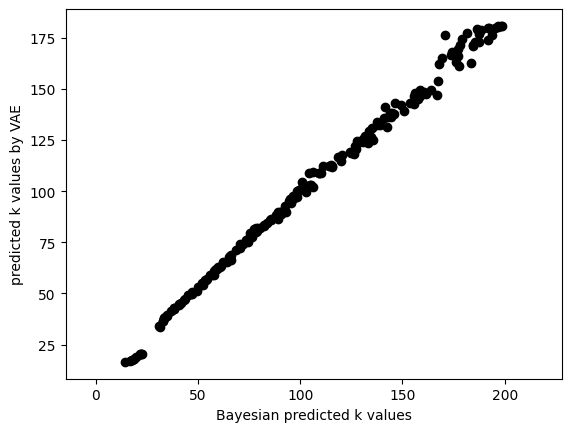

In [ ]:
## Test Data
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(km_list, decoded_data_test_rescaled[:,-1]))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(km_list, decoded_data_test_rescaled[:,-1]))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(km_list, decoded_data_test_rescaled[:,-1],  color='black')
plt.xlabel('Bayesian predicted k values')
plt.ylabel('predicted k values by VAE')
ax.axis('equal');

In [ ]:
# Here is the expression from the image written in Python code.

def temperature_profile(x, k, q = 1000, L = 0.2, h = 12.5, T_surr = 295):
    return q * ((L - x) / k + 1 / h) + T_surr

# Position within the material
x = 0.02       # Position at which to evaluate the temperature

# Calculate the temperature at x
T_x = temperature_profile(x, k)
T_x

376.10592283116245